In [1]:
'''
Notes

в пределах 10мб - не мусорные контакты
всю Hi-C карту предсказывать не надо. участки вдоль диагонали
посмотреть гитхаб Fudenberg'а

удалить главную диагональ? - схлопывать

'''

"\nNotes\n\nв пределах 10мб - не мусорные контакты\nвсю Hi-C карту предсказывать не надо. участки вдоль диагонали\nпосмотреть гитхаб Fudenberg'а\n\nудалить главную диагональ? - схлопывать\n\n"

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas

pandas.set_option('display.max_columns', 500)
pandas.set_option('display.max_rows', 500)

import h5py
import random

import math
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

import cooler

from Bio import SeqIO

import pickle

In [21]:
# the following directive activates inline plotting
%matplotlib inline

# allow to allocate resources for model training
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True

In [22]:
from tensorflow.keras.backend import set_session
sess = tf.Session(config=config)
set_session(sess)

In [4]:
# UTIL FUNCTIONS

In [5]:
def plot_hic(matrix):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    im = ax.matshow(np.log10(matrix), cmap='YlOrRd')
    fig.colorbar(im)

In [6]:
def one_hot_dna(sequence):
    seq_array = np.array(list(sequence))

    label_encoder = LabelEncoder()
    integer_encoded_seq = label_encoder.fit_transform(seq_array)
    
    integer_encoded_seq = integer_encoded_seq.reshape(len(integer_encoded_seq), 1)
    
    onehot_encoder = OneHotEncoder(sparse = False)
    return onehot_encoder.fit_transform(integer_encoded_seq)

In [7]:
# На данный момент я предсказываю и обучаюсь на окнах размером 50x50. В терминах последовательности это 50.000 нуклеотидов
def select_training_squares(hic_matrix):
    training_set = []
    
    # WINDOW_SIZE = 50 # For Fudenberg (+mine) conv NN
    
    # For Basset Conv Neural Network (it has much less inputs)
    WINDOW_SIZE = 25
    
    for i in range(0, hic_matrix.shape[0], (WINDOW_SIZE // 10)):
        # TODO: здесь я не рассматриваю квадрат, если в нем есть хотя бы один np.nan
        # наверное можно не делать такое строгое отсеивание, а отсеивать, если процент nan'ов больше 5, например
        if np.sum(np.isnan(hic_matrix[i:(i + WINDOW_SIZE), i:(i + WINDOW_SIZE)])) == 0:
            training_set.append((hic_matrix[i:(i + WINDOW_SIZE), i:(i + WINDOW_SIZE)], (i, (i + WINDOW_SIZE))))
            
    return training_set

In [8]:
def form_train_x(training_squares, current_seq_one_hot):
    train_x = []
    
    for training_square in training_squares:
        sq_begin, sq_end = training_square[1]
        train_x.append(current_seq_one_hot[(sq_begin * 1000):(sq_end * 1000), ])
    
    return np.asarray(train_x)

In [9]:
def form_train_y(training_squares):
    train_y = []
    
    for training_square in training_squares:
        # it's possible to use training_square[0].reshape(2500, 1) here if this option doesn't work
        train_y.append(training_square[0].flatten())
        
    return np.asarray(train_y)

In [23]:
filepath = "S2-Wang2017-async.dm3.mapq_30.100.mcool"
resolution = "::/resolutions/1000" # 1 KB resolution

# Colab specific code
# filepath = "drive/My Drive/Colab Notebooks/S2-Wang2017-async.dm3.mapq_30.100.mcool"

c = cooler.Cooler(filepath + resolution)
arr = c.matrix(balance=True).fetch('chr3R')

/Users/neil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


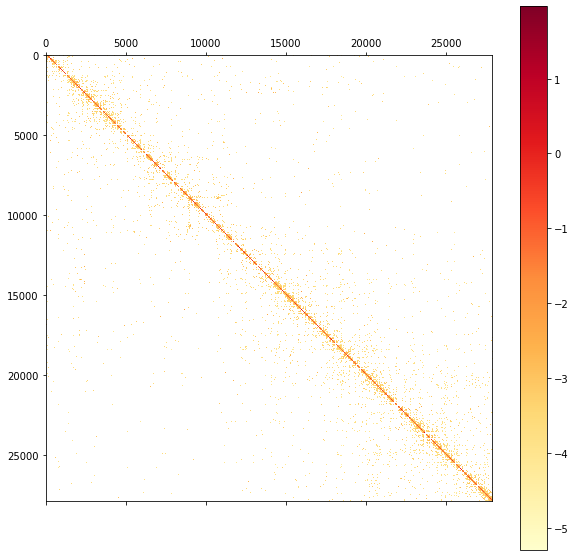

In [7]:
plot_hic(arr)

In [24]:
fasta_file = "chr3R.fa"
fasta_sequence = list(SeqIO.parse(open(fasta_file),'fasta'))[0]

name, sequence = fasta_sequence.id, str(fasta_sequence.seq)

In [25]:
# Вопрос: Не точно совпадают длины последовательности и HI-C
print(len(sequence))
print(arr.shape[0] * 1000)

27905053
27906000


In [26]:
# Решение: обрезаю Hi-C и последовательность ДНК до одинаковых размеров
current_matrix = arr[0:27905, 0:27905]
current_seq = sequence[0:(27905 * 1000)]

In [27]:
# Воспринимаю маленькие и большие буквы одинаковым образом (??? Это норм ???)
current_seq = current_seq.upper()

In [28]:
# Преобразую последовательность в one-hot encoding (A = 0, C = 1, G = 2, T = 3)
current_seq_one_hot = one_hot_dna(current_seq)

/Users/neil/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [29]:
training_squares = select_training_squares(current_matrix)

In [30]:
train_x = form_train_x(training_squares, current_seq_one_hot)

In [31]:
train_y = form_train_y(training_squares)

In [32]:
train_x.shape

(6050, 25000, 4)

In [33]:
train_y.shape

(6050, 625)

In [29]:
# Convnet model (similar to Fudenberg NN):

model_m = Sequential()

model_m.add(layers.Conv1D(25, 50, activation='relu', input_shape=(50000, 4)))
model_m.add(layers.Conv1D(25, 50, activation='relu'))
model_m.add(layers.MaxPooling1D(5, strides = 2))

model_m.add(layers.Conv1D(50, 25, activation='relu'))
model_m.add(layers.MaxPooling1D(5, strides = 2))

model_m.add(layers.Conv1D(50, 25, activation='relu'))
model_m.add(layers.MaxPooling1D(20, strides = 4))

model_m.add(layers.Conv1D(70, 20, activation='relu'))
model_m.add(layers.MaxPooling1D(25, strides = 4))

# dilated layers
model_m.add(layers.Conv1D(100, 15, activation='relu', dilation_rate = 2))
model_m.add(layers.Conv1D(100, 15, activation='relu', dilation_rate = 2))
model_m.add(layers.MaxPooling1D(25, strides = 4))

model_m.add(layers.Flatten())
model_m.add(layers.Dense(2500, activation='linear'))

# здесь можно не использовать входы (50 штук) и схлопывать после предсказания НС
# не 2.500, а 2.450
# для тренировки и для предсказаний надо будет сначала делать трансформацию для вектора

print(model_m.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 49951, 25)         5025      
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 49902, 25)         31275     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 24949, 25)         0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 24925, 50)         31300     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 12461, 50)         0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 12437, 50)         62550     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 3105, 50)         

In [30]:
model_m.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='mse',
              metrics=['mae'])

In [ ]:
history = model_m.fit(train_x,
                      train_y,
                      batch_size=32,
                      epochs=3,
                      verbose=1)

In [31]:
model_m.load_weights('project2_model_1.h5')

/Users/neil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


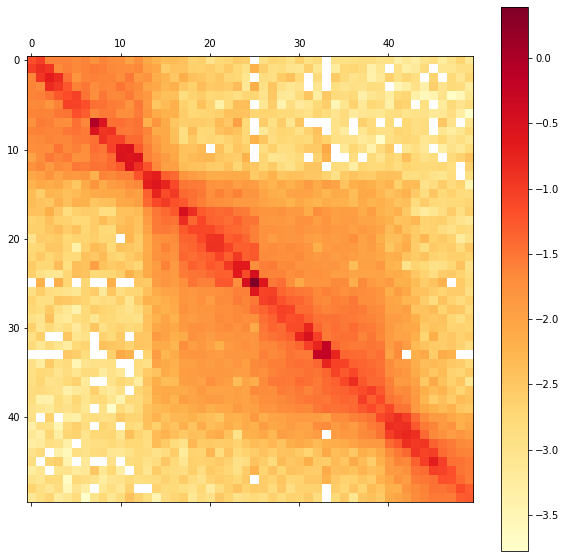

In [32]:
plot_hic(training_squares[0][0])

In [34]:
sq_begin, sq_end = training_squares[0][1]
seq_to_use = current_seq_one_hot[(sq_begin * 1000):(sq_end * 1000), ].reshape((1,50000, 4))

In [37]:
prediction = model_m.predict(seq_to_use)

/Users/neil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


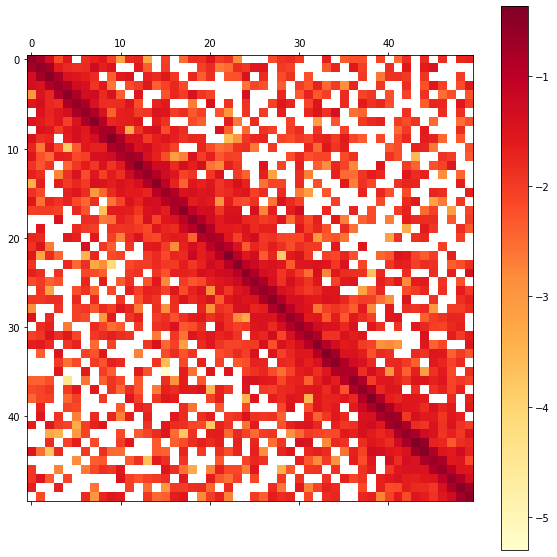

In [39]:
plot_hic(prediction.reshape((50, 50)))

In [50]:
model_m.load_weights('project2_model_2.h5')

/Users/neil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


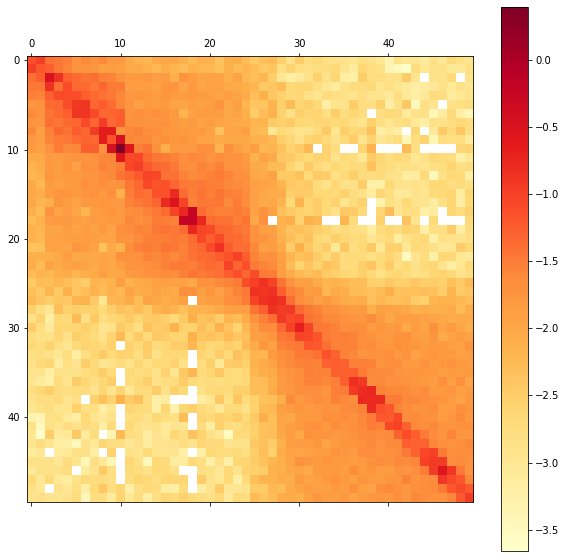

In [57]:
plot_hic(training_squares[3][0])

In [60]:
sq_begin, sq_end = training_squares[3][1]
seq_to_use = current_seq_one_hot[(sq_begin * 1000):(sq_end * 1000), ].reshape((1,50000, 4))

In [61]:
prediction = model_m.predict(seq_to_use)

/Users/neil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


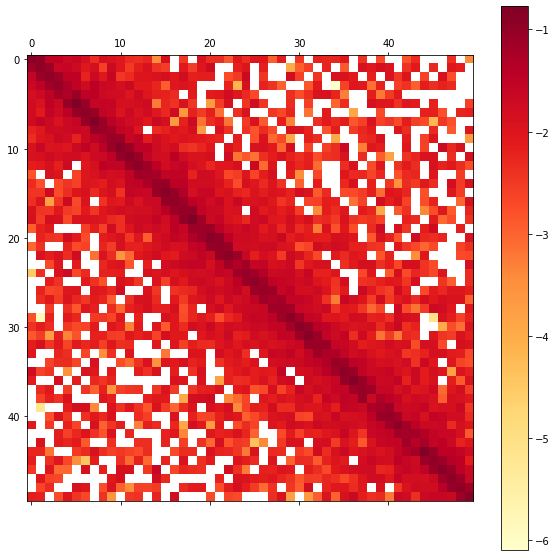

In [62]:
plot_hic(prediction.reshape((50, 50)))

In [ ]:
# Fudenberg избавляется от scaling'а
# избавиться от шкалирования. полимерное свойство хроматина нам не обязательно выучивать
# Нам надо это делать:
# observed/expected - Саша отправит
# можно применять observed/expected для всей хромосомы или для каждого квардрата 50x50
# для каждого квардрата делать observed/expected

In [ ]:
# Басет работа - 2015 (размеры слоев и параметры оттуда)
# В басет предсказывается DNA sequence -> accessibility (open versus closed chromatin) of this area 
# (in different cell types)

In [34]:
# Convnet model (similar to Basset NN):
# Basset NN is not trainable in a reasonable time with this 50x50 window size -> reduced to 25x25 window size
# Nevertheless, 3 times more tunable parameters than Fudenberg

model_m = Sequential()

model_m.add(layers.Conv1D(300, 21, activation='relu', input_shape=(25000, 4)))
model_m.add(layers.MaxPooling1D(4))

model_m.add(layers.Conv1D(300, 6, activation='relu'))
model_m.add(layers.MaxPooling1D(4))

model_m.add(layers.Conv1D(500, 4, activation='relu'))
model_m.add(layers.MaxPooling1D(4))

model_m.add(layers.Flatten())

model_m.add(layers.Dense(1000, activation='relu'))

model_m.add(layers.Dense(625, activation='linear'))

print(model_m.summary())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 24980, 300)        25500     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 6245, 300)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6240, 300)         540300    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1560, 300)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1557, 500)         600500    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 389, 500)          0         
____

In [35]:
model_m.load_weights('project2_model_Basset.h5')

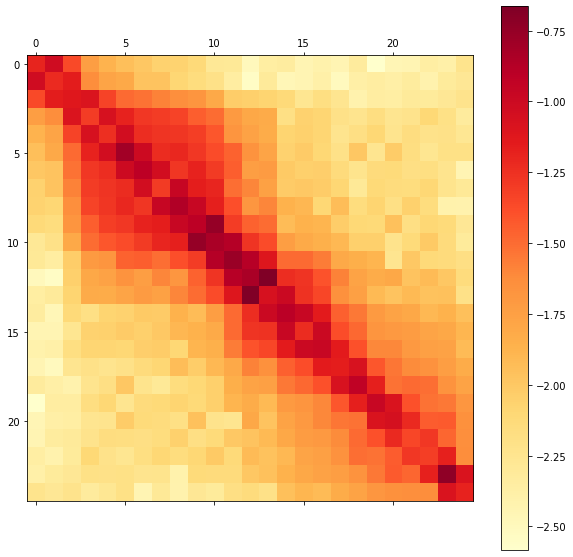

In [36]:
plot_hic(training_squares[3][0])

In [37]:
sq_begin, sq_end = training_squares[3][1]
seq_to_use = current_seq_one_hot[(sq_begin * 1000):(sq_end * 1000), ].reshape((1,25000, 4))

In [38]:
prediction = model_m.predict(seq_to_use)

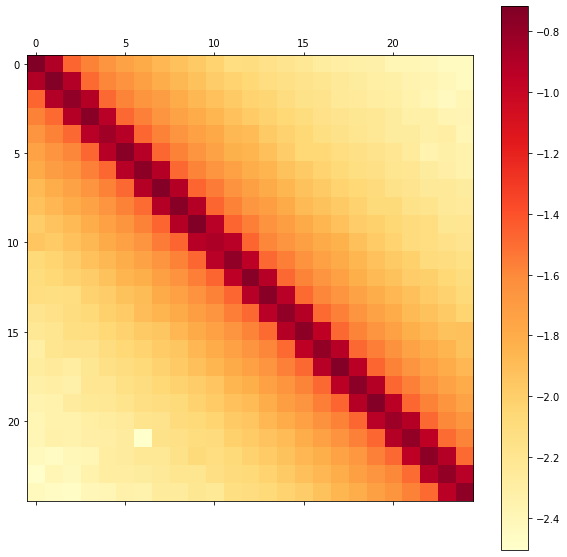

In [39]:
plot_hic(prediction.reshape((25, 25)))